# Maestría en Inteligencia Artificial Aplicada
 Curso: Ciencia de Datos
### Tecnológico de Monterrey
- Prof María de la Paz Rico Fernández
- Tutor Orlando Figon

- Reto-> Parte II

 Clasificación-ensambles 

Usaré la base de datos de superficiales ya que tiene mayor correlación con la zona y esto ayudará a poder hacer un deepdive más a detalle

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import geopandas as gpd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

In [2]:
df_superficiales = pd.read_csv('Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv',
                                encoding= 'latin1')

Ahora limpiamos el data set como lo hicimos anteriormente para poder tener los datos más relevantes

In [3]:
columnas_faltantes = pd.DataFrame(df_superficiales.isna().sum() /len(df_superficiales)).sort_values(by= 0, ascending= False)
sin_info = columnas_faltantes.iloc[[columnas_faltantes.loc[x] > 0.5 for x in columnas_faltantes.index]].index
col_eliminar = columnas_faltantes.iloc[[columnas_faltantes.loc[x] > 0.5 for x in columnas_faltantes.index]].index

In [4]:
df_superficiales = df_superficiales.drop(col_eliminar, axis= 1)
df_superficiales.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [5]:
superficial_col_id = ['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
                     'CUENCA', 'CUERPO DE AGUA', 'TIPO', 'SUBTIPO', 'GRUPO']

superficial_col_categorica = [x for x in df_superficiales.columns if x[0:7] == 'CALIDAD'] + ['CONTAMINANTES'] + [x for x in df_superficiales.columns if x[0:6]=='CUMPLE']

superficial_col_medida = [x for x in df_superficiales.columns if x[-1] == 'L']

superficial_col_localizacion = ['LONGITUD', 'LATITUD']

y = ['SEMAFORO']

In [6]:

pipe_categoricas = make_pipeline(SimpleImputer(strategy= 'most_frequent'), LabelEncoder())


transformer = make_column_transformer((pipe_categoricas, superficial_col_categorica))

Seguimos con la normalización para los datos que parecen ser continuos pero realmente se notaba desde la entrega 1 que eran categóricos

In [7]:
def normalizar(df,v,umbral):
    aux = df[v].value_counts(normalize=True).to_frame()
    aux[f'n_{v}'] = np.where(aux[v] < umbral , 'Otros', aux.index)

    moda = aux.head(1)[f'n_{v}'].values[0]

    if aux.loc[aux[f'n_{v}'] == 'Otros' ][v].sum() < umbral:
        aux[f'n_{v}'].replace( {'Otros':moda} , inplace=True)

    aux.drop(v, axis=1, inplace=True)
    aux.reset_index(inplace=True)

    return df.merge(aux,left_on=[v], right_on='index', how='inner').drop('index',axis=1)

In [8]:
for col in superficial_col_medida:
    df_superficiales = normalizar(df_superficiales, col, 0.05)

df_superficiales.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO,n_DBO_mg/L,n_DQO_mg/L,n_SST_mg/L,n_COLI_FEC_NMP_100mL,n_E_COLI_NMP_100mL
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,SI,ND,SI,SI,LENTICO,Otros,Otros,Otros,Otros,Otros
1,DLSAN2308M1,PUENTE PASO AL BALCON,GOLFO NORTE,SAN LUIS POTOSI,TIERRA NUEVA,RIO SANTA MARIA 1,RIO SANTA MARIA,LOTICO,RIO,-100.43365,...,SI,ND,SI,SI,LOTICO,<2,<10,<10,Otros,Otros
2,DLCOA434,"PRESA VENUSTIANO CARRANZA, SURESTE",RIO BRAVO,COAHUILA DE ZARAGOZA,JUAREZ,RIO SALADO,PRESA VENUSTIANO CARRANZA,LENTICO (HUMEDAL),PRESA,-100.61208,...,SI,ND,SI,SI,LENTICO,<2,Otros,Otros,Otros,Otros
3,OCPNO4455,RIO CULIACAN PUENTE USE,PACIFICO NORTE,SINALOA,CULIACAN,RIO CULIACAN,RIO CULIACAN,LOTICO,RIO,-107.44814,...,SI,ND,SI,SI,LOTICO,<2,<10,Otros,Otros,Otros
4,OCPNO4622,RIO PRESIDIO 1,PACIFICO NORTE,SINALOA,MAZATLAN,RIO PRESIDIO 2,RIO PRESIDIO,LOTICO,RIO,-106.23032,...,SI,ND,SI,SI,LOTICO,<2,Otros,Otros,Otros,Otros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,OCPNO4651,AGUAS DEBAJO DE LA DESCARGA DE LA CD. EL ROSARIO,PACIFICO NORTE,SINALOA,ROSARIO,RIO BALUARTE 2,RIO BALUARTE,LOTICO (HUMEDAL),RIO,-105.86382,...,NO,ND,SI,SI,LOTICO,Otros,Otros,Otros,Otros,Otros
2574,OCLSP3709M1,RIO BOLAÑOS ANTES DE LA POBLACION,LERMA SANTIAGO PACIFICO,JALISCO,BOLAÑOS,RIO BOLAÑOS 1,RIO BOLAÑOS,LOTICO,RIO,-103.77389,...,NO,ND,SI,SI,LOTICO,Otros,Otros,Otros,Otros,Otros
2575,OCLSP3764M1,RIO BOLAÑOS PUENTE EN SAN MARTIN DE BOLAÑOS,LERMA SANTIAGO PACIFICO,JALISCO,SAN MARTIN DE BOLAÑOS,RIO BOLAÑOS 2,RIO SANTIAGO,LOTICO A - Tipo 10,RIO,-103.81025,...,NO,ND,SI,SI,LOTICO,Otros,Otros,Otros,Otros,Otros
2576,OCLSP3904M1,RIO SAN NICOLAS PUENTE CARRETERA A PUERTO VALL...,LERMA SANTIAGO PACIFICO,JALISCO,LA HUERTA,RIO SAN NICOLAS A,RIO SAN NICOLAS,LOTICO (HUMEDAL),RIO,-105.18233,...,NO,ND,SI,SI,LOTICO,Otros,Otros,Otros,Otros,Otros


In [9]:
varn = df_superficiales.filter(like='n_').columns.tolist()
unarias = [v for v,conteo in zip(varn, [ df_superficiales[v].unique().shape[0] for v in varn ] ) if conteo == 1]
print(unarias)
varn = [v for v in varn  if v not in unarias]

[]


In [16]:
superficial_col_categorica += varn

Cambiamos el encoding

In [10]:
df_superficiales.SEMAFORO= df_superficiales.SEMAFORO.replace({'Rojo':1,'Verde':2, 'Amarillo':3})

Seleccionamos nuestras variables de predicción

In [17]:
for col in superficial_col_categorica:
    df_superficiales[col] = LabelEncoder().fit_transform(df_superficiales[col])

In [18]:
X_cols = superficial_col_localizacion + superficial_col_categorica 
y = ['SEMAFORO']

Veamos el feature importance con el desicion tree

In [19]:
len(X_cols)

21

DecisionTreeClassifier()
21


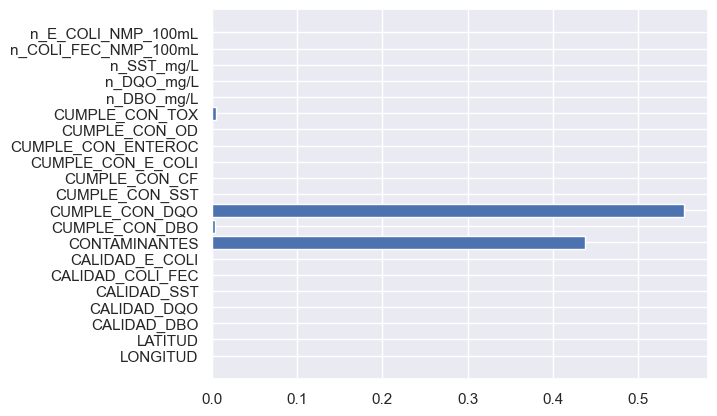

RandomForestClassifier(max_depth=5, n_estimators=1000)
21


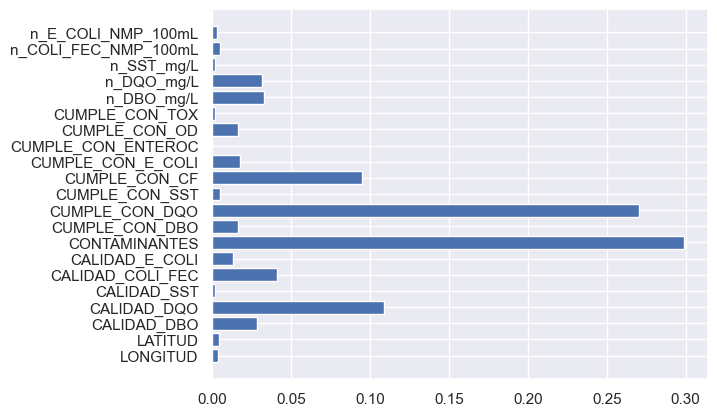

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


models = [DecisionTreeClassifier(), RandomForestClassifier(n_estimators= 1000, max_depth= 5)]
data_importancias = pd.DataFrame()
for model in models:
    print(model)
    model_pipe = model

    model_pipe.fit(X= df_superficiales[X_cols], y=df_superficiales.SEMAFORO)
    importancias = model_pipe.feature_importances_
    print(len(importancias))
    feature_importance_sk = {}
    for i, feature in enumerate(X_cols):
        feature_importance_sk[feature] = round(importancias[i], 5)
    plt.barh(df_superficiales[X_cols].columns, importancias)
    plt.show()
    data_importancias =  pd.concat([pd.DataFrame(feature_importance_sk, index=[1]), data_importancias])


Nos quedaremos con random forest con las variables más importantes

In [28]:
data_importancias.index = ['tree', 'forest']
data_importancias.T.sort_values(by= 'forest', ascending= False).head(10)


,tree,forest
CUMPLE_CON_DQO,0.27022,0.55416
CONTAMINANTES,0.29902,0.43744
CUMPLE_CON_TOX,0.00174,0.00479
CUMPLE_CON_DBO,0.01636,0.00362
LONGITUD,0.00371,0.00000
CUMPLE_CON_E_COLI,0.01798,0.00000
n_COLI_FEC_NMP_100mL,0.00546,0.00000
n_SST_mg/L,0.00223,0.00000
n_DQO_mg/L,0.03186,0.00000
n_DBO_mg/L,0.03308,0.00000


In [30]:
var_mas_imp = data_importancias.T.sort_values(by= 'forest', ascending= False).head(10).index

Ahora sí entrenamos bien nuestro modelo

In [34]:
from sklearn.model_selection import train_test_split

Xt, Xv, yt, yv = train_test_split(df_superficiales[X_cols], df_superficiales.SEMAFORO, stratify=df_superficiales.SEMAFORO)

In [46]:
from sklearn.model_selection import RandomizedSearchCV
params = {'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth': np.arange(2,10)}
search = RandomizedSearchCV(estimator= RandomForestClassifier(),
                            param_distributions= params,
                            n_iter= 10,
                            n_jobs= -1)

search.fit(Xt, yt)
print(f'La mejor combinación de parametros fue: {search.best_params_}')
print('Dando un score de:')
print(search.best_score_)
best_model = search.best_estimator_

best_model.fit(Xt, yt)

y_predic = best_model.predict(Xv)

La mejor combinación de parametros fue: {'max_depth': 7, 'criterion': 'entropy'}
Dando un score de:
0.9979314776880749


In [48]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['Sem 1', 'Sem 2', 'Sem 3']
print(classification_report(yv, y_predic, target_names= target_names))

              precision    recall  f1-score   support

       Sem 1       1.00      0.99      1.00       234
       Sem 2       0.99      1.00      1.00       136
       Sem 3       1.00      1.00      1.00       275

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



Ya vemos que el modelo fue perfecto al hacerlo raro pero son datos que ya veíamos eran separables


Y como vemos en la matriz de confusión se ven bien clasificados

<AxesSubplot: >

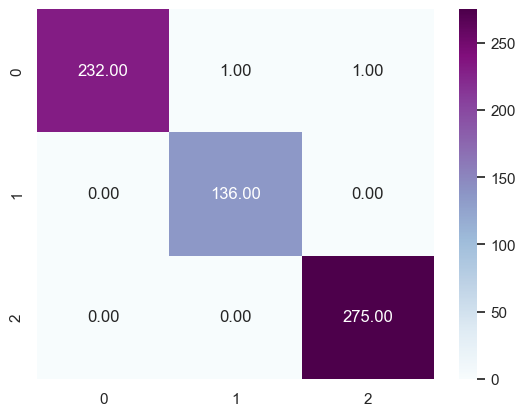

In [54]:
sns.heatmap(confusion_matrix(yv, y_predic), cmap = 'BuPu', annot= True, fmt='0.2f')

## Fin entrega 2